In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import warnings

from scipy.special import expit

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

## Question 1

Rerun the first model using the petal length and then petal width variables. What are the main differences in the results? How wide or narrow is the 95% HPD interval in each case?

<p><font color="blue">
    <p>Model that uses `petal_length` produces a wider 94% HPD interval than the one that uses `petal_width` for predicting `species`, 95% HPD intervals are 1.01 and 0.344 respectively.</p>
</font></p>

In [3]:
iris = pd.read_csv("../BAP/code/data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris_df = iris.query("species == ('setosa', 'versicolor')")

y = pd.Categorical(iris_df['species']).codes
X = iris_df[["petal_length", "petal_width"]].values
Xc = X - np.mean(X, axis=0)
Xc.shape, y.shape

((100, 2), (100,))

In [5]:
with pm.Model() as model_q1a:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + pm.math.dot(Xc[:, 0], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q1a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2999.68draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
hpd = az.stats.hpd(trace_q1a["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.84927948,  0.18407235]), 1.0333518317540684)

In [7]:
with pm.Model() as model_q1b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + pm.math.dot(Xc[:, 1], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q1b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3488.38draws/s]
The acceptance probability does not match the target. It is 0.8861845106371918, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
hpd = az.stats.hpd(trace_q1b["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.19751128,  0.13890003]), 0.33641130952184317)

## Question 2

Repeat exercise 1, this time using a Student's t-distribution as a weakly informative prior. Try different values of $\nu$.

<p><font color="blue">
    <p>Results are not very different when switching out the Gaussian prior for $\beta$ with a Student-T distribution -- the `petal_length` feature still results in a larger HPD compared to the `petal_width` feature. Different value of $\nu$ does not result in lot of difference in HPD spreads either.</p>
    <p><table cellspacing=0 cellpadding=0 border=1>
        <tr>
            <th>X</th>
            <th>nu</th>
            <th>HPD-lb</th>
            <th>HPD-ub</th>
            <th>HPD-intvl</th>
        </tr>
        <tr>
            <td>petal_length</td>
            <td>30</td>
            <td>-0.81</td>
            <td>0.20</td>
            <td>1.02</td>
        </tr>
        <tr>
            <td>petal_width</td>
            <td></td>
            <td>-0.21</td>
            <td>0.13</td>
            <td>0.34</td>
        </tr>
        <tr>
            <td>petal_length</td>
            <td>10</td>
            <td>-0.82</td>
            <td>0.19</td>
            <td>1.01</td>
        </tr>
        <tr>
            <td>petal_width</td>
            <td></td>
            <td>-0.21</td>
            <td>0.13</td>
            <td>0.34</td>
        </tr>
        <tr>
            <td>petal_length</td>
            <td>10</td>
            <td>-0.84</td>
            <td>0.17</td>
            <td>1.02</td>
        </tr>
        <tr>
            <td>petal_width</td>
            <td></td>
            <td>-0.21</td>
            <td>0.14</td>
            <td>0.35</td>
        </tr>
    </table></p>
</font>
</p>

In [9]:
with pm.Model() as model_q2a:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.StudentT('β', mu=0, sd=10, nu=30)
    μ = α + pm.math.dot(Xc[:, 0], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q2a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2998.20draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
hpd = az.stats.hpd(trace_q2a["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.82996841,  0.201246  ]), 1.031214409854596)

In [11]:
with pm.Model() as model_q2b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.StudentT('β', mu=0, sd=10, nu=30)
    μ = α + pm.math.dot(Xc[:, 1], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q2b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3510.10draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8793340525497708, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
hpd = az.stats.hpd(trace_q2b["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.21755996,  0.12959487]), 0.3471548249681454)

In [13]:
with pm.Model() as model_q2a:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.StudentT('β', mu=0, sd=10, nu=10)
    μ = α + pm.math.dot(Xc[:, 0], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q2a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2731.75draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
hpd = az.stats.hpd(trace_q2a["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.79544804,  0.20841241]), 1.0038604462889793)

In [15]:
with pm.Model() as model_q2b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.StudentT('β', mu=0, sd=10, nu=10)
    μ = α + pm.math.dot(Xc[:, 1], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q2b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3337.94draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7156194484998349, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9011118528476516, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [16]:
hpd = az.stats.hpd(trace_q2b["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.21056258,  0.13998409]), 0.350546673599186)

In [17]:
with pm.Model() as model_q2a:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.StudentT('β', mu=0, sd=10, nu=100)
    μ = α + pm.math.dot(Xc[:, 0], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q2a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2985.22draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
hpd = az.stats.hpd(trace_q2a["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.81069776,  0.19179279]), 1.0024905498145742)

In [19]:
with pm.Model() as model_q2b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.StudentT('β', mu=0, sd=10, nu=100)
    μ = α + pm.math.dot(Xc[:, 1], β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q2b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3372.33draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
hpd = az.stats.hpd(trace_q2b["bd"], credible_interval=0.95)
hpd_intvl = hpd[1] - hpd[0]
hpd, hpd_intvl

(array([-0.2007389 ,  0.13520682]), 0.33594572241382276)

## Question 3

Go back to the first example, the logistic regression for classifying setosa or versicolor given sepal length. Try to solve the same problem using a simple linear regression model, as we saw in Chapter 3, Modeling with Linear Regression. How useful is linear regression compared to logistic regression? Can the result be interpreted as a probability? Tip, check whether the values of y are restricted to the \[0, 1\] interval.

<p><font color="blue">The predicted values of y_pred fall outside the range [0, 1] so they cannot be interpreted as probability.</font></p>

In [21]:
y = pd.Categorical(iris_df['species']).codes
x = iris_df[["sepal_length"]].values
xc = x - np.mean(x, axis=0)
xc[:,0].shape, y.shape

((100,), (100,))

In [22]:
with pm.Model() as model_q3:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic("μ", α + β * xc[:, 0])
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
#     θ = pm.Deterministic("θ", α + β * Xc[:, 0])
#     y_pred = pm.Bernoulli("y_pred", p=pm.math.invlogit(θ), observed=y)
    trace_q3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3675.79draws/s]


In [23]:
spp_q3 = pm.sample_posterior_predictive(trace_q3, 100, model_q3)
y_pred = spp_q3["y_pred"].reshape(-1, 1)
np.min(y_pred), np.max(y_pred)

100%|██████████| 100/100 [00:00<00:00, 1149.23it/s]


(-1.422427296550224, 2.415126618529802)

## Question 4

In the example from the Interpreting the coefficients of a logistic regression section, we changed sepal_length by 1 unit. Using Figure 4.6, corroborate that the value of log_odds_versicolor_i corresponds to the value of
probability_versicolor_i. Do the same for log_odds_versicolor_f and probability_versicolor_f. Just by noting log_odds_versicolor_i is negative, what can you say about the probability? Use Figure 4.6 to help you. Is
this result clear to you from the definition of log-odds?

In [24]:
y = pd.Categorical(iris_df['species']).codes
X = iris_df[["sepal_length", "sepal_width"]].values
Xc = X - np.mean(X, axis=0)
Xc.shape, y.shape

((100, 2), (100,))

In [25]:
with pm.Model() as model_q4:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=2)
    μ = α + pm.math.dot(Xc, β)
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q4 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3350.03draws/s]


In [26]:
az.summary(trace_q4, var_names=["α", "β"])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.39,0.50,0.01,-0.53,1.34,6366.0,1.0
β[0],5.08,1.01,0.01,3.26,7.04,5837.0,1.0
β[1],-5.06,0.99,0.02,-6.87,-3.19,6804.0,1.0


In [27]:
coeffs = az.summary(trace_q4, var_names=["α", "β"])["mean"].values

# initial values for (const, sepal_length, sepal_width), 
# increasing sepal_length by 1
feats_i = [1, 4.5, 3]
feats_f = [1, 5.5, 3]

logit_i = (coeffs * feats_i).sum()
logit_f = (coeffs * feats_f).sum()

proba_i = expit(logit_i)
proba_f = expit(logit_f)

print("log_odds   : initial: {:.3f}, final: {:.3f}".format(logit_i, logit_f))
print("proba      : initial: {:.3f}, final: {:.3f}".format(proba_i, proba_f))
print("difference : log_odds({:.3f}) => proba({:3f})".format(logit_f - logit_i,
                                                             proba_f - proba_i))

log_odds   : initial: 8.070, final: 13.150
proba      : initial: 1.000, final: 1.000
difference : log_odds(5.080) => proba(0.000311)


## Question 5

Use the same example from the previous exercise. For model_1, check how much the log-odds change when increasing sepal_length from 5.5 to 6.5 (spoiler: it should be $\beta$\[0\]). How much does the probability change? How does this increase compare to when we increase from 4.5 to 5.5?

In [28]:
feats_i = [1, 5.5, 4.5]
feats_f = [1, 6.5, 4.5]

logit_i = (coeffs * feats_i).sum()
logit_f = (coeffs * feats_f).sum()

proba_i = expit(logit_i)
proba_f = expit(logit_f)

print("difference : log_odds({:.3f}) => proba({:3f})".format(logit_f - logit_i,
                                                             proba_f - proba_i))

difference : log_odds(5.080) => proba(0.003810)


## Question 6

In the example for dealing with unbalanced data, change df = df[45:] to df = df[22:78]. This will keep roughly the same number of data points, but now the classes will be balanced. Compare the new result with the previous ones. Which one is more similar to the example using the complete dataset?

<p><font color="blue">
    <p>Result is more similar to the plot for the complete dataset (figure 4.5) than the df[45:] example (figure 4.8).</p>
</font></p>

In [29]:
iris_df = iris.query("species == ('setosa', 'versicolor')")
iris_df = iris_df[22:78]
y = pd.Categorical(iris_df['species']).codes
colnames = ['sepal_length', 'sepal_width']
X = iris_df[colnames].values

X.shape, y.shape

((56, 2), (56,))

In [30]:
with pm.Model() as model_q6:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=len(colnames))
    μ = α + pm.math.dot(X, β)
    θ = 1 / (1 + pm.math.exp(-μ))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X[:,0])
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q6 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:07<00:00, 773.57draws/s]
The acceptance probability does not match the target. It is 0.8791503932749339, but should be close to 0.8. Try to increase the number of tuning steps.


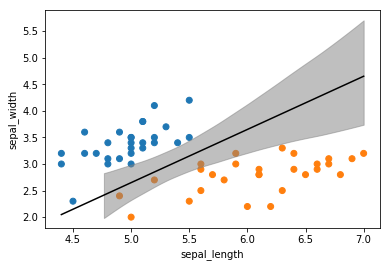

In [31]:
idx = np.argsort(X[:,0])

bd = trace_q6['bd'].mean(0)[idx]

plt.scatter(X[:, 0], X[:, 1], c= [f'C{l}' for l in y])
plt.plot(X[:, 0][idx], bd, color='k')
az.plot_hpd(X[:, 0], trace_q6['bd'], color='gray')
plt.xlabel(colnames[0])
plt.ylabel(colnames[1])
_ = plt.show()

## Question 7

Suppose instead of a softmax regression, we use a simple linear model by coding (setosa = 0, versicolor = 1, and virginica = 2). Under the simple linear regression model, what will happen if we switch the coding? Will we get the same or different results?

<p><font color="blue"><p>We should get different coefficients for the two linear models, since with the simple coding described, the three species have a numeric relationship to each other, i.e., with the current coding setosa &lt; versicolor &lt; virginica, whereas with the reversed coding it would imply setosa &gt; versicolor &gt; virginica. Hence coefficients will change.</p></font></p>

## Question 8

Compare the likelihood of the logistic model versus the likelihood of the LDA model. Use the `sample_posterior_predictive` function to generate predicted data, and compare the types of data you get for both cases. Be sure you understand the difference between the types of data the model predicts.

In [32]:
iris_df = iris.query("species == ('setosa', 'versicolor')")

y = pd.Categorical(iris_df['species']).codes
X = iris_df[["petal_length", "petal_width"]].values
Xc = X - np.mean(X, axis=0)
Xc.shape, y.shape

((100, 2), (100,))

In [33]:
with pm.Model() as model_q8_logistic:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=2)
    μ = α + pm.math.dot(Xc, β)
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * Xc[:, 0])
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    trace_q8_logistic = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2692.97draws/s]


In [34]:
with pm.Model() as model_q8_lda:
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=Xc[:50])  # setosa
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ, observed=Xc[50:])  # versicolor
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_q8_lda = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3287.99draws/s]


In [35]:
az.summary(trace_q8_logistic)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,1.00,1.31,0.02,-1.27,3.60,3005.0,1.0
β[0],4.14,1.23,0.02,2.04,6.61,3926.0,1.0
β[1],1.75,1.80,0.03,-1.59,5.10,4486.0,1.0
θ[0],0.01,0.01,0.00,0.00,0.02,7078.0,1.0
θ[1],0.01,0.01,0.00,0.00,0.02,7078.0,1.0
...,...,...,...,...,...,...,...
bd[95],-3.24,142.93,1.55,-33.28,27.27,7851.0,1.0
bd[96],-3.24,142.93,1.55,-33.28,27.27,7851.0,1.0
bd[97],-3.42,151.05,1.64,-34.72,29.50,7849.0,1.0
bd[98],-1.09,48.96,0.52,-7.68,7.19,7956.0,1.0


In [36]:
pp_q8_logistic = pm.sample_posterior_predictive(trace_q8_logistic, 100, model_q8_logistic)
pp_q8_logistic, pp_q8_logistic.keys()

100%|██████████| 100/100 [00:00<00:00, 2100.13it/s]


({'y_pred': array([[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]])},
 dict_keys(['y_pred']))

In [37]:
az.summary(trace_q8_lda)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ[0],-0.97,0.05,0.0,-1.07,-0.87,5589.0,1.0
μ[1],0.97,0.05,0.0,0.87,1.06,5160.0,1.0
σ,0.51,0.03,0.0,0.47,0.56,5105.0,1.0
bd,0.00,0.04,0.0,-0.07,0.07,5921.0,1.0


In [38]:
pp_q8_lda = pm.sample_posterior_predictive(trace_q8_lda, 100, model_q8_lda)
pp_q8_lda, pp_q8_lda.keys()

100%|██████████| 100/100 [00:00<00:00, 592.55it/s]


({'setosa': array([[[-0.88494451, -1.84021663],
          [-1.54460001, -1.09286214],
          [-0.94949233, -0.71392794],
          ...,
          [-1.47828353, -1.64582156],
          [-0.84464474, -1.03143867],
          [-1.15824386, -1.34464449]],
  
         [[-0.86379571, -0.59803326],
          [-0.49868077, -0.62056058],
          [-0.50994884, -0.62315517],
          ...,
          [-0.85780206, -1.48784646],
          [-0.67784308, -2.0949224 ],
          [-0.43018248, -0.76077922]],
  
         [[-0.66118265, -1.03302923],
          [-0.4749032 , -0.83307967],
          [-0.96888823, -0.72352132],
          ...,
          [-1.58428085, -0.64987982],
          [-0.29217912, -1.06283388],
          [-0.12784836, -0.69075326]],
  
         ...,
  
         [[-1.6269759 , -1.42103246],
          [-1.21644735, -1.18217096],
          [-1.46436776, -0.97655063],
          ...,
          [-0.7227777 , -1.494851  ],
          [-0.14090609, -1.22522669],
          [-0.56823372, -1.

## Question 9

Using the fish data, extend the ZIP_reg model to include the persons variable as part of a linear model. Include this variable to model the number of extra zeros. You should get a model that includes two linear models: one connecting the number of children and the presence/absence of a camper to the Poisson rate (as in the example we saw), and another connecting the number of persons to the variable. For the second case, you will need a logistic inverse link!

In [39]:
fish_df = pd.read_csv("../BAP/code/data/fish.csv")
fish_df.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [40]:
with pm.Model() as model_q9:

    # from example
    ψ0 = pm.Beta('ψ', 1, 1)
    α0 = pm.Normal('α0', 0, 10)
    β0 = pm.Normal('β0', 0, 10, shape=2)
    θ0 = pm.Deterministic("θ0", pm.math.exp(α0 + β0[0] * fish_df['child'] + β0[1] * fish_df['camper']))
    comp_0 = pm.ZeroInflatedPoisson.dist(ψ0, θ0)

    # person linear model
    α1 = pm.Normal('α1', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    θ1 = pm.Deterministic("θ1", α1 + β1 * fish_df["persons"])
    comp_1 = pm.Bernoulli.dist(p=pm.math.invlogit(θ1))
    
    # mixture
    w = pm.Dirichlet("w", a=np.array([1, 1]))
    y_pred = pm.Mixture("y_pred", w=w, comp_dists=[comp_0, comp_1], observed=fish_df['count'])
    
    trace_q9 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, β1, α1, β0, α0, ψ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:22<00:00, 263.00draws/s]
The acceptance probability does not match the target. It is 0.7171482551541492, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6722363873114168, but should be close to 0.8. Try to increase the number of tuning steps.


In [41]:
az.summary(trace_q9, var_names=["w"])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
w[0],0.88,0.02,0.0,0.85,0.92,1681.0,1.0
w[1],0.12,0.02,0.0,0.08,0.15,1681.0,1.0


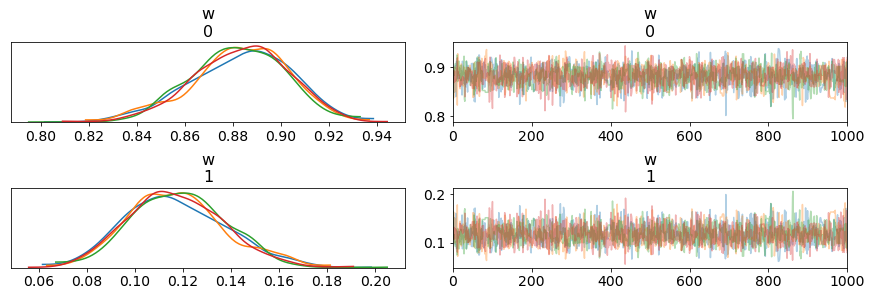

In [42]:
_ = az.plot_trace(trace_q9, var_names=["w"])

## Question 10

Use the data for the robust logistic example to feed a non-robust logistic regression model and to check that the outliers actually affected the results. You may want to add or remove outliers to better understand the effect of the
estimation on a logistic regression and the robustness on the model introduced in this chapter.

<p><font color="blue">
    <p>Non-robust model is unable to account for outliers. Double checked this by using non-robust model on data including and excluding outlers, latter model is better able to account for the data.</p>
</font></p>

In [43]:
iris_df = iris.query("species == ('setosa', 'versicolor')")

x0 = iris_df["sepal_length"].values
y0 = pd.Categorical(iris_df['species']).codes

# add in some outliers
x = np.concatenate((x0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
y = np.concatenate((y0, np.ones(6, dtype=int)))

xc = x - x.mean()
xc.shape, y.shape

((106,), (106,))

In [44]:
with pm.Model() as model_q10a:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + xc * β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
#     π = pm.Beta('π', 1., 1.)
#     p = π * 0.5 + (1 - π) * θ
#     yl = pm.Bernoulli('yl', p=p, observed=y_0)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    
    trace_q10a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3633.41draws/s]


In [45]:
az.summary(trace_q10a, var_names=["α", "β"])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.23,0.24,0.00,-0.23,0.69,3993.0,1.0
β,2.37,0.48,0.01,1.51,3.32,3672.0,1.0


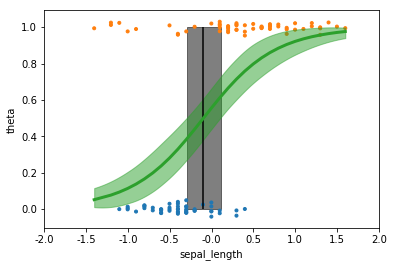

In [46]:
theta = trace_q10a['θ'].mean(axis=0)
idx = np.argsort(xc)

plt.plot(xc[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_q10a['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_q10a['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(xc, np.random.normal(y, 0.02), marker='.', color=[f'C{l}' for l in y])
az.plot_hpd(xc, trace_q10a['θ'], color='C2')
plt.xlabel("sepal_length")
plt.ylabel("theta")
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + xc.mean(), 1))

_ = plt.show()

In [47]:
# remove outliers
xc = xc[0:100]
y = y[0:100]

xc.shape, y.shape

((100,), (100,))

In [48]:
with pm.Model() as model_q10b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + xc * β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    y_pred = pm.Bernoulli('y_pred', p=θ, observed=y)
    
    trace_q10b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3724.46draws/s]


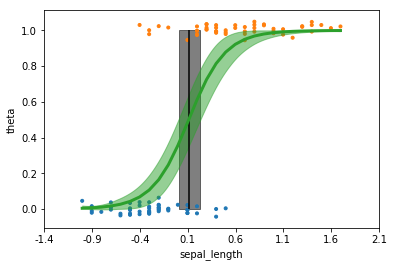

In [49]:
theta = trace_q10b['θ'].mean(axis=0)
idx = np.argsort(xc)

plt.plot(xc[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_q10b['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_q10b['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(xc, np.random.normal(y, 0.02), marker='.', color=[f'C{l}' for l in y])
az.plot_hpd(xc, trace_q10b['θ'], color='C2')
plt.xlabel("sepal_length")
plt.ylabel("theta")
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + xc.mean(), 1))

_ = plt.show()

## Question 11

Read and run the following notebooks from PyMC3's documentation:
* [GLM: Linear Regression](https://docs.pymc.io/notebooks/GLM-linear.html)
* [GLM: Robust Linear Regression](https://docs.pymc.io/notebooks/GLM-robust.html)
* [GLM: Hierarchical Linear Regression](https://docs.pymc.io/notebooks/GLM-hierarchical.html)
